# Polynomial Loc-Scale-Regression

## Setup and Imports

In [24]:
import jax
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [25]:
rng = np.random.default_rng(1)
x = rng.uniform(-2, 2, 200)

log_sigma = -0.2 * x
mu = -x + x**2
y = mu + jnp.exp(log_sigma) * rng.normal(0.0, 1.0, 200)

df = pd.DataFrame({"y": y, "x": x})

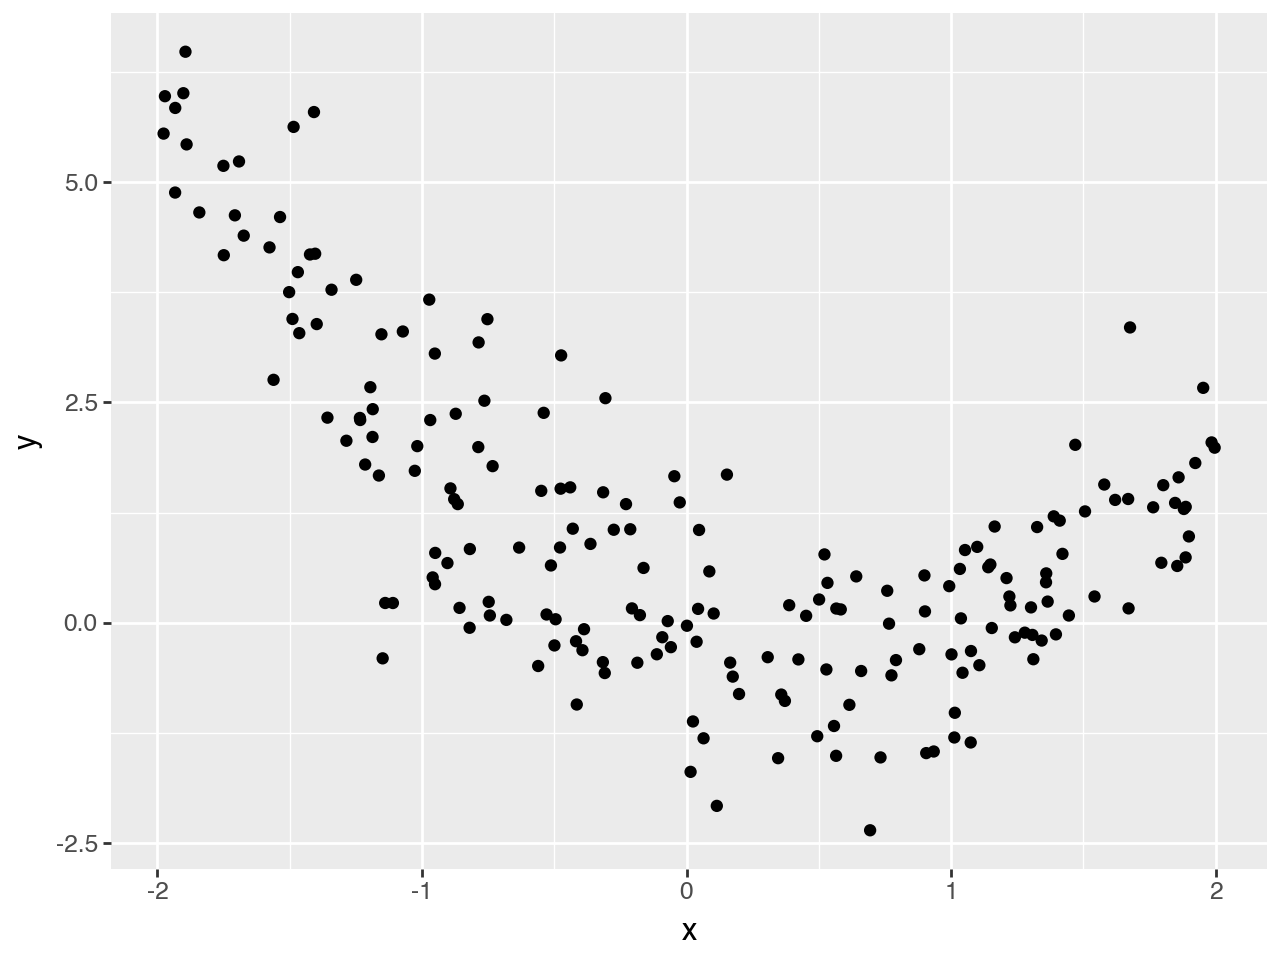

In [26]:
(p9.ggplot(df) + p9.geom_point(p9.aes("x", "y")))

## Model Definition

In [27]:
loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.y.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

In [28]:
tb = gam.TermBuilder.from_df(df)

In [29]:
loc += tb.lin("x + {x**2}")
scale += tb.lin("x")

### Build and plot model

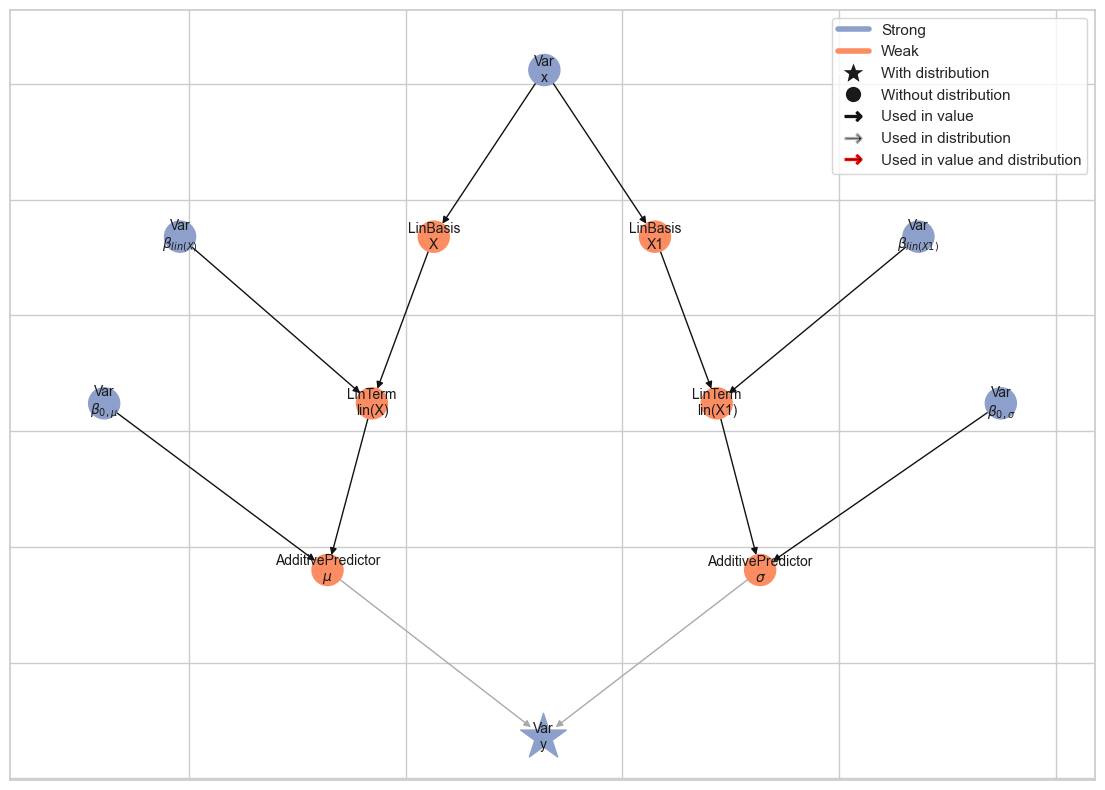

In [30]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [31]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.add_burnin(1000)
eb.add_posterior(10_000, thinning=10)

engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\beta_{0,\\sigma}$', '$\\beta_{lin(X1)}$', '$\\beta_{0,\\mu}$', '$\\beta_{lin(X)}$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: BURNIN, 1000 transitions, 1000 jitted together
100%|██████████████████████████████████████████| 1/1 [00:03<00:00,  3.22s/chunk]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Finished warmup
liesel.goose.engine - INFO - Starting epoch: POSTERIOR, 10000 transitions, 1000 jitted together
100%|████████████████████████████████████████| 10/10 [00:01<00:00,  9.27chunk/s]
liesel.goose.engine - INFO - Finished epoch


### MCMC summary

In [32]:
summary = gs.Summary(results)
summary

Parameter summary:

                             kernel      mean        sd    q_0.05     q_0.5  \
parameter          index                                                      
$\beta_{0,\mu}$    ()     kernel_02 -0.120440  0.094327 -0.278698 -0.121568   
$\beta_{0,\sigma}$ ()     kernel_00 -0.101203  0.051107 -0.184955 -0.101575   
$\beta_{lin(X)}$   (0,)   kernel_03 -1.026619  0.060915 -1.126641 -1.027187   
                   (1,)   kernel_03  1.033473  0.056802  0.942452  1.033228   
$\beta_{lin(X1)}$  (0,)   kernel_01 -0.140698  0.050012 -0.222453 -0.140182   

                            q_0.95  sample_size     ess_bulk     ess_tail  \
parameter          index                                                    
$\beta_{0,\mu}$    ()     0.034348         4000  2880.892280  3405.121153   
$\beta_{0,\sigma}$ ()    -0.015275         4000  3836.126101  3838.462468   
$\beta_{lin(X)}$   (0,)  -0.926506         4000  3783.204421  3641.794017   
                   (1,)   1.129125         4000  2829.652664  3701.969987   
$\beta_{lin(X1)}$  (0,)  -0.056971         4000  4095.049144  3817.189105   

                              rhat  
parameter          index            
$\beta_{0,\mu}$    ()     1.000439  
$\beta_{0,\sigma}$ ()     0.999941  
$\beta_{lin(X)}$   (0,)   0.999428  
                   (1,)   1.000731  
$\beta_{lin(X1)}$  (0,)   1.001336

### MCMC trace plots

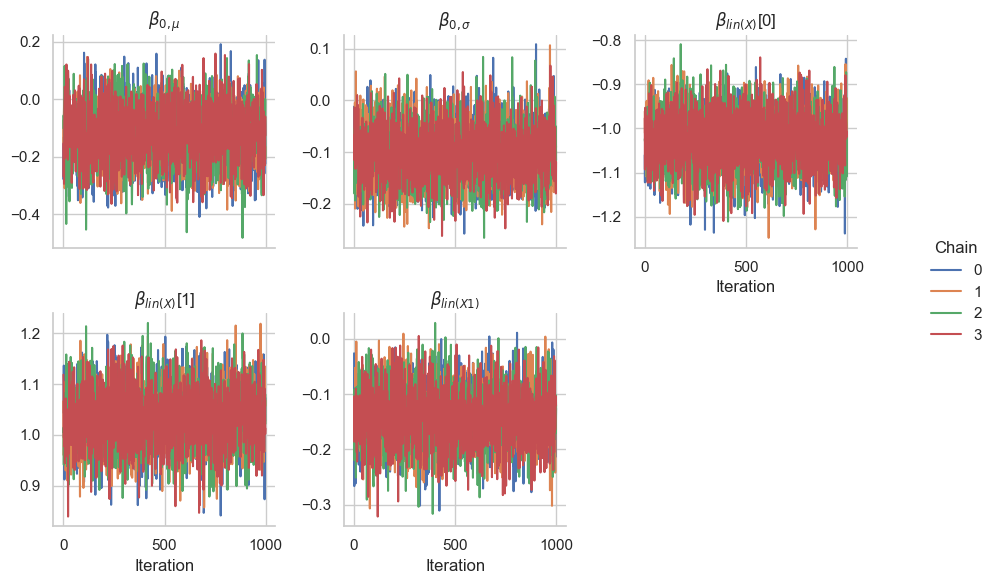

In [33]:
gs.plot_trace(results)

## Predictions

In [34]:
samples = results.get_posterior_samples()

### Predict variables at new x values

In [35]:
x_grid = jnp.linspace(x.min(), x.max(), 300)
predictions = model.predict(
    samples=samples,
    predict=["lin(X)", "lin(X1)", "$\\mu$", "$\\sigma$"],
    newdata={"x": x_grid},
)

predictions_summary = gs.SamplesSummary(predictions).to_dataframe().reset_index()
predictions_summary["x"] = np.tile(x_grid, len(predictions))

In [36]:
predictions_summary.head()

,variable,var_fqn,var_index,sample_size,mean,var,sd,ess_bulk,ess_tail,mcse_mean,mcse_sd,rhat,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high,x
0,$\mu$,$\mu$[0],"(0,)",4000,5.947023,0.059801,0.244543,3230.505662,3651.905009,0.004305,0.002774,0.999674,5.534438,5.949018,6.350981,5.569644,6.370417,-1.976702
1,$\mu$,$\mu$[1],"(1,)",4000,5.879270,0.058344,0.241546,3239.614025,3651.586267,0.004247,0.002739,0.999643,5.471073,5.881016,6.278395,5.511409,6.302707,-1.963415
2,$\mu$,$\mu$[2],"(2,)",4000,5.811897,0.056917,0.238573,3245.814362,3687.244032,0.004190,0.002705,0.999632,5.408678,5.813008,6.206538,5.448952,6.231711,-1.950128
3,$\mu$,$\mu$[3],"(3,)",4000,5.744873,0.055519,0.235625,3252.757797,3687.244032,0.004133,0.002671,0.999623,5.346520,5.745001,6.134404,5.382929,6.156501,-1.936841
4,$\mu$,$\mu$[4],"(4,)",4000,5.678220,0.054150,0.232702,3261.208882,3651.458166,0.004076,0.002637,0.999619,5.284647,5.678637,6.062679,5.323129,6.088024,-1.923554


### Plot fitted functions

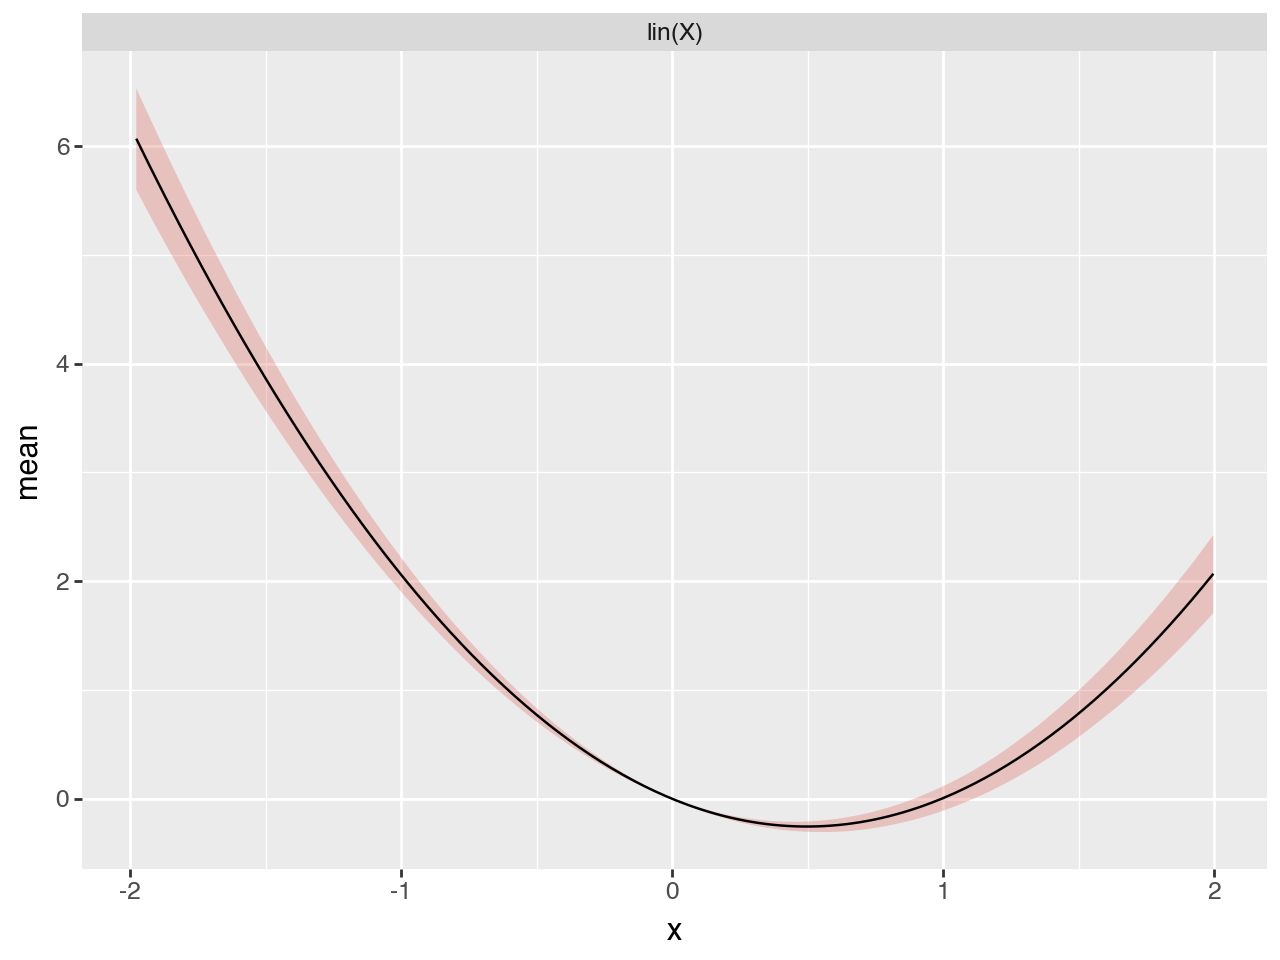

In [37]:
select = predictions_summary["variable"].isin(["lin(X)", "lin(X2)"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

### Plot parameters as functions of covariate

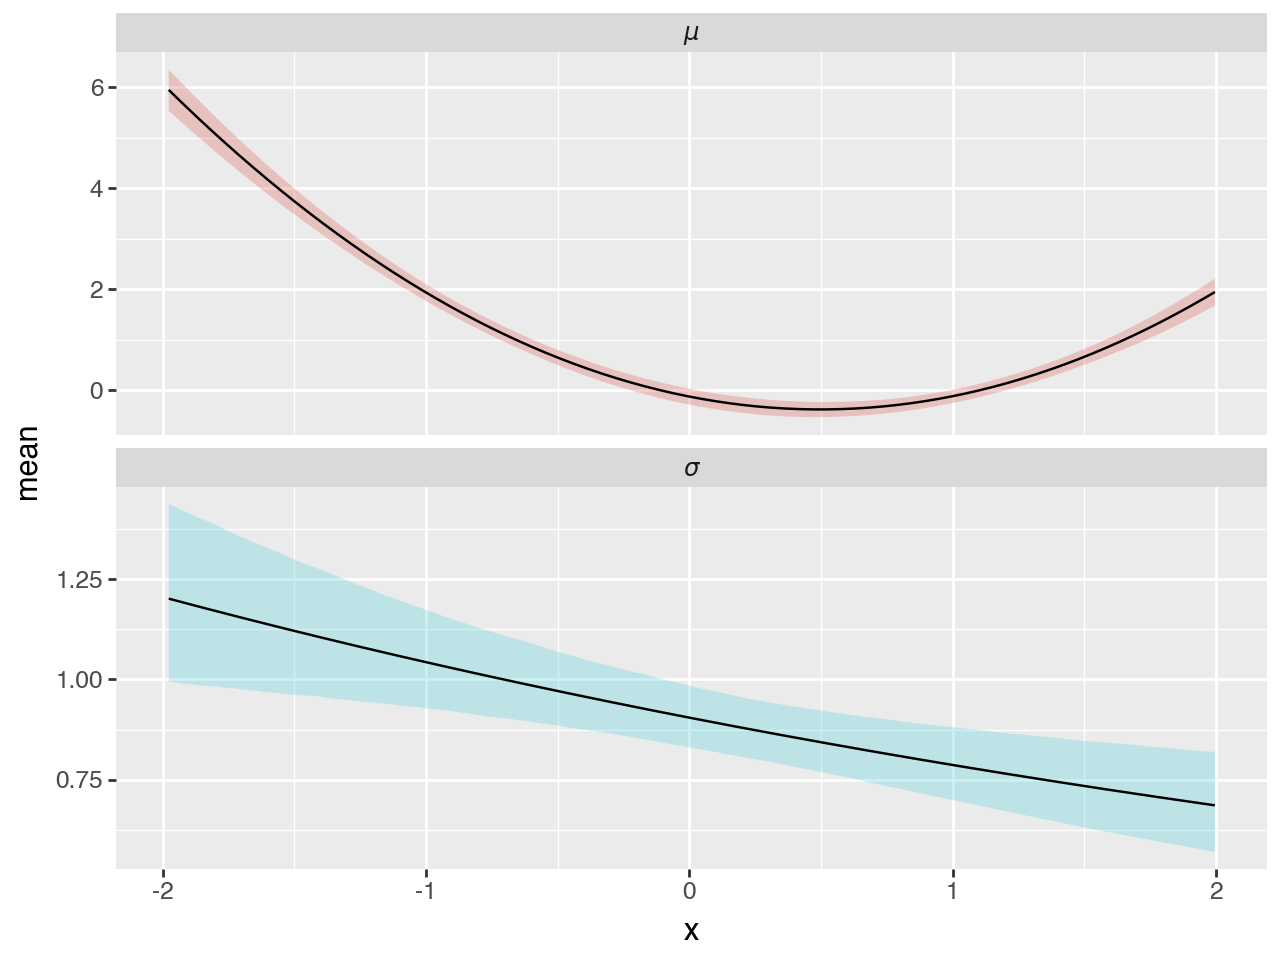

In [38]:
select = predictions_summary["variable"].isin(["$\\mu$", "$\\sigma$"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

### Plot mean function with data

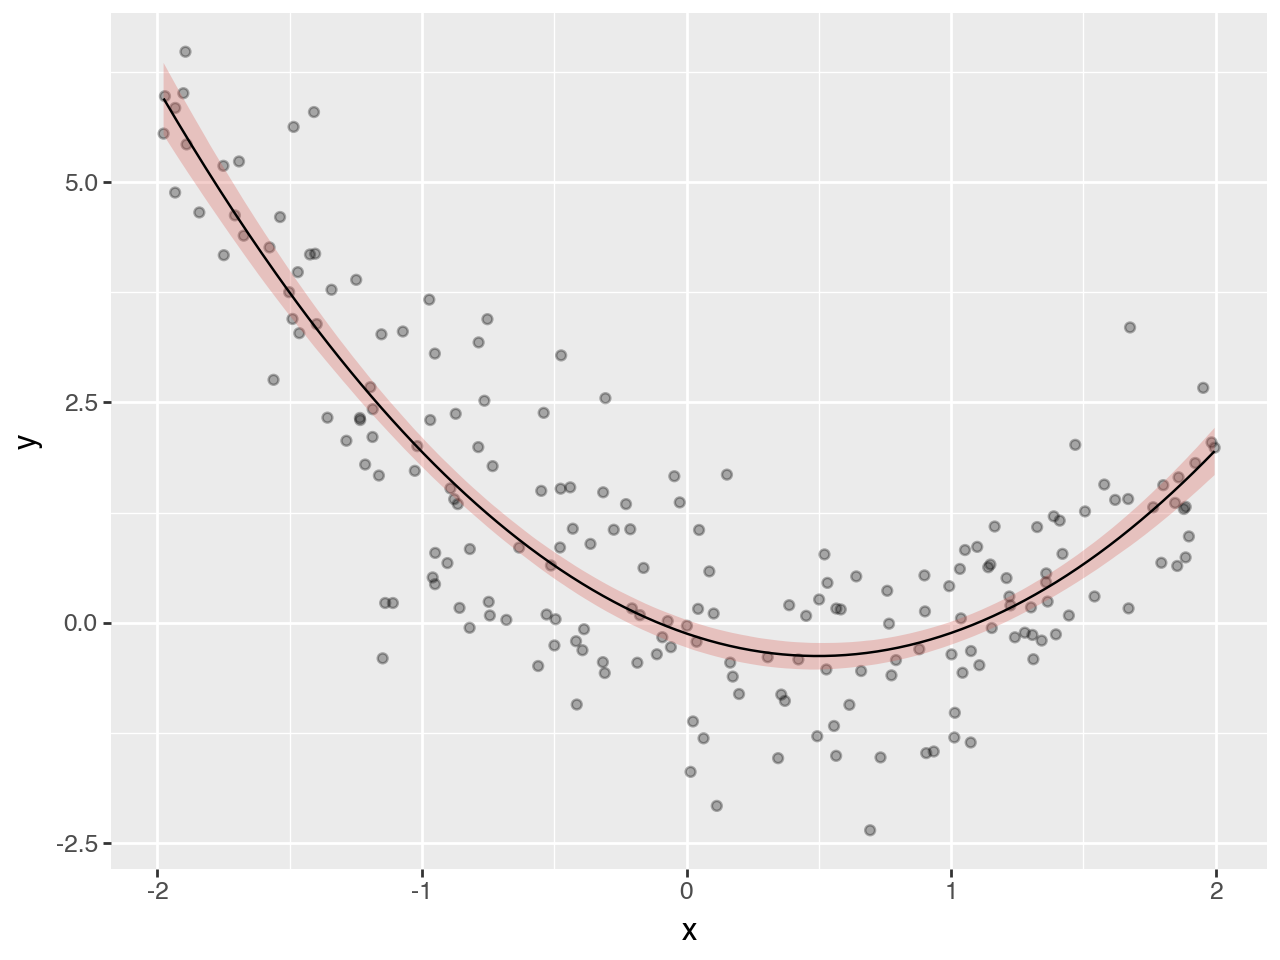

In [39]:
select = predictions_summary["variable"].isin(["$\\mu$"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.guides(fill="none")
)

### Plot average posterior predictive distribution

In [40]:
select = predictions_summary["variable"].isin(["$\\mu$", "$\\sigma$"])
mu_sigma_df = (
    predictions_summary[select][["variable", "mean", "x"]]
    .pivot(index="x", columns=["variable"], values="mean")
    .reset_index()
)

mu_sigma_df["low"] = mu_sigma_df["$\\mu$"] - mu_sigma_df["$\\sigma$"]
mu_sigma_df["high"] = mu_sigma_df["$\\mu$"] + mu_sigma_df["$\\sigma$"]
mu_sigma_df

variable,x,$\mu$,$\sigma$,low,high
0,-1.976702,5.947023,1.201194,4.745830,7.148217
1,-1.963415,5.879270,1.198869,4.680401,7.078139
2,-1.950128,5.811897,1.196550,4.615346,7.008447
3,-1.936841,5.744873,1.194239,4.550634,6.939112
4,-1.923554,5.678220,1.191927,4.486293,6.870147
...,...,...,...,...,...
295,1.942956,1.786320,0.691626,1.094695,2.477946
296,1.956243,1.826223,0.690378,1.135845,2.516601
297,1.969530,1.866492,0.689135,1.177358,2.555627
298,1.982817,1.907126,0.687889,1.219238,2.595015


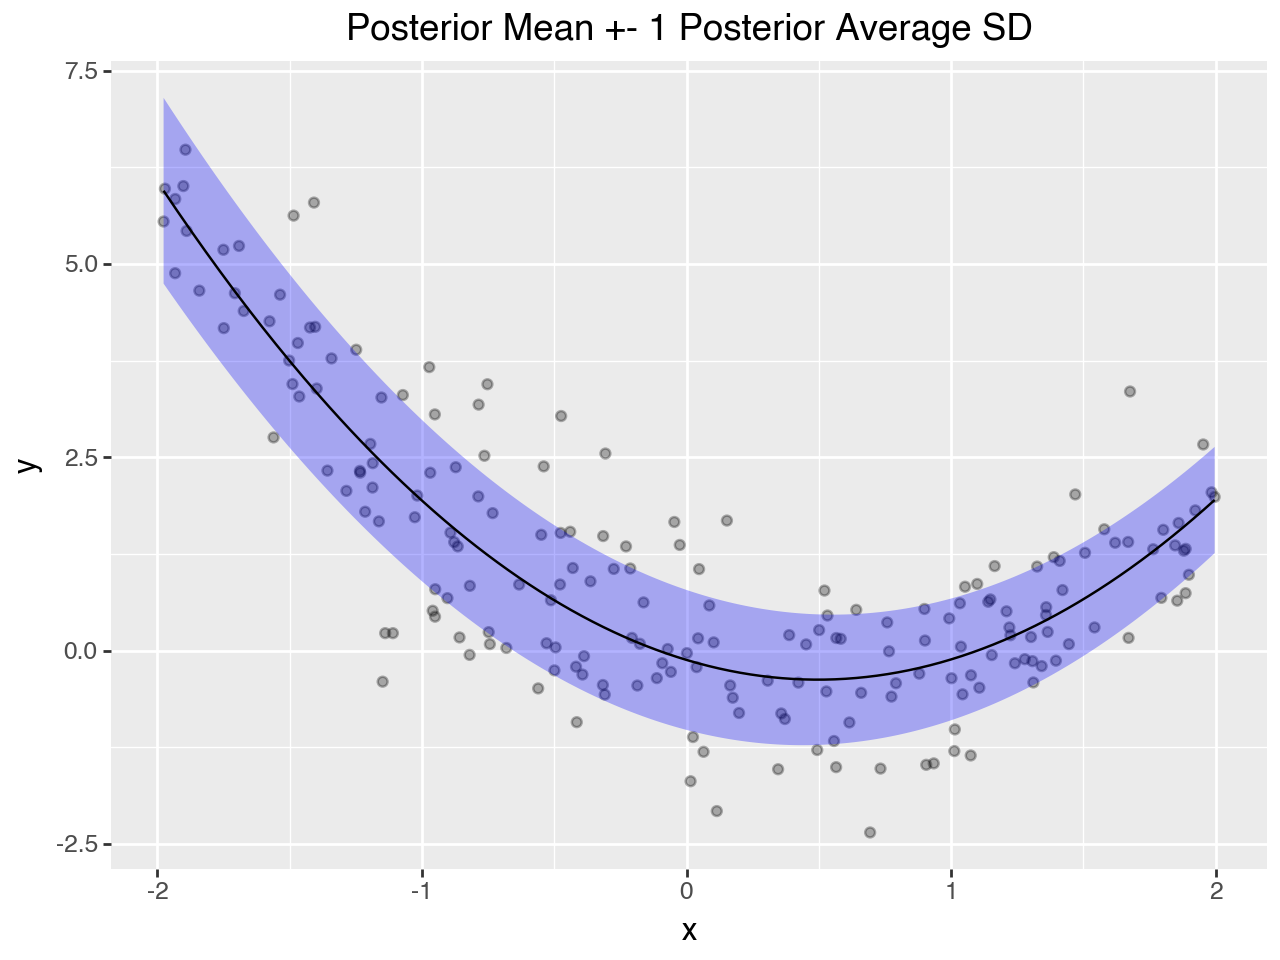

In [41]:
(
    p9.ggplot()
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="low", ymax="high"),
        alpha=0.3,
        fill="blue",
        data=mu_sigma_df,
    )
    + p9.geom_line(p9.aes("x", "$\\mu$"), data=mu_sigma_df)
    + p9.labs(title="Posterior Mean +- 1 Posterior Average SD")
    + p9.guides(fill="none")
)

## Posterior Predictive Checks

### Draw posterior predictive samples

In [42]:
ppsamples = model.sample(shape=(3,), seed=jax.random.key(1), posterior_samples=samples)

ppsamples["y"].shape

(3, 4, 1000, 200)

In [43]:
# can be reshaped to concatenate the first two axes
_ = ppsamples["y"].reshape(-1, *ppsamples["y"].shape[2:])

### Summarize posterior predictive samples

In [44]:
ppsamples = model.sample(
    shape=(),  # just draw 1 value for each posterior sample
    seed=jax.random.key(1),
    posterior_samples=samples,
)

# summarise ppsamples
ppsamples_summary = gs.SamplesSummary(ppsamples).to_dataframe().reset_index()

# add covariate to df
ppsamples_summary["x"] = df["x"].to_numpy()

### Plot posterior predictive summary

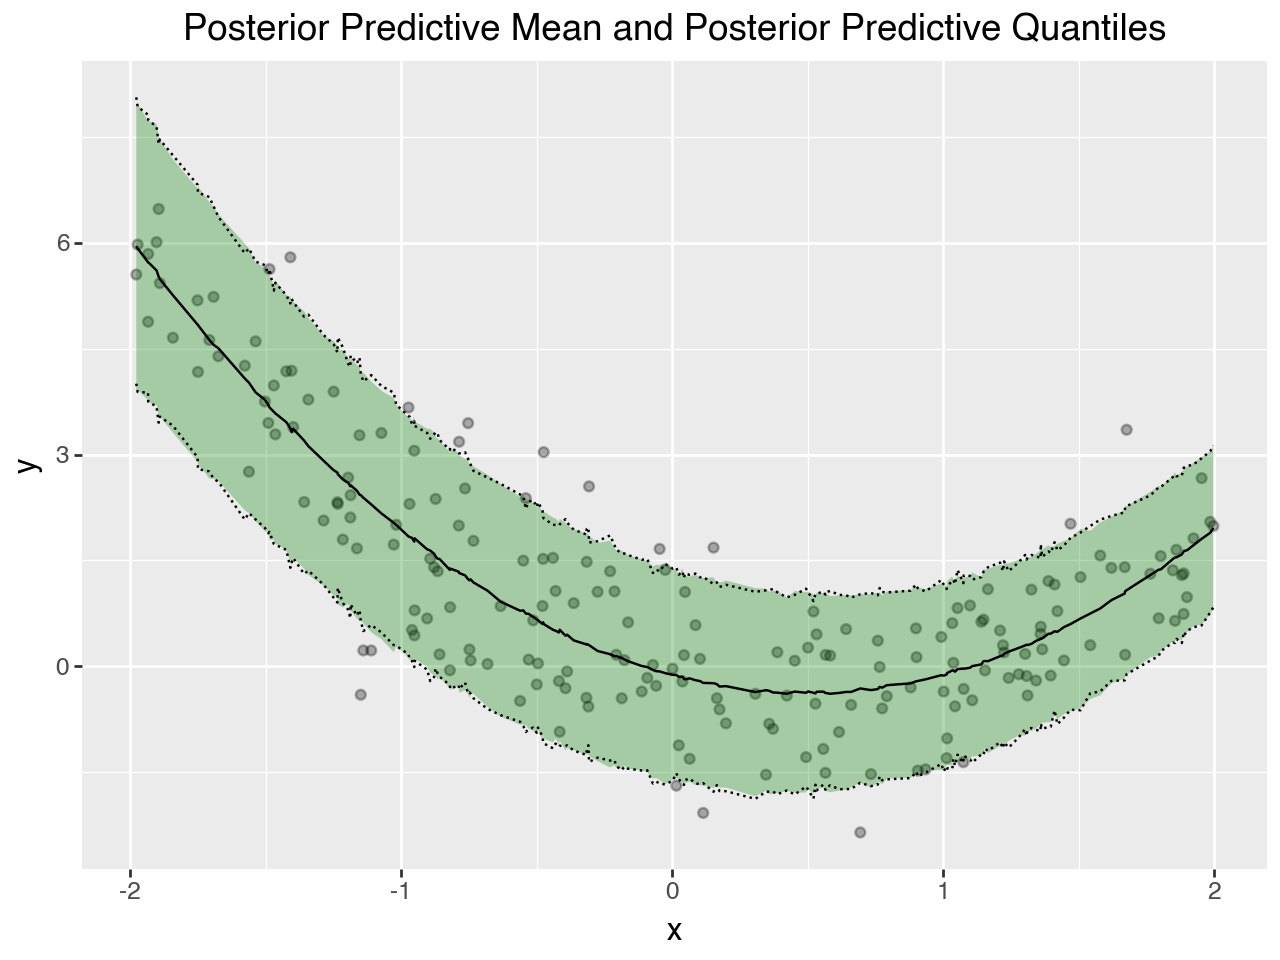

In [45]:
(
    p9.ggplot(ppsamples_summary)
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95"),
        alpha=0.3,
        fill="green",
    )
    + p9.geom_line(p9.aes("x", "hdi_low"), linetype="dotted")
    + p9.geom_line(p9.aes("x", "hdi_high"), linetype="dotted")
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.labs(title="Posterior Predictive Mean and Posterior Predictive Quantiles")
    + p9.guides(fill="none")
)

### Plot posterior predictive samples

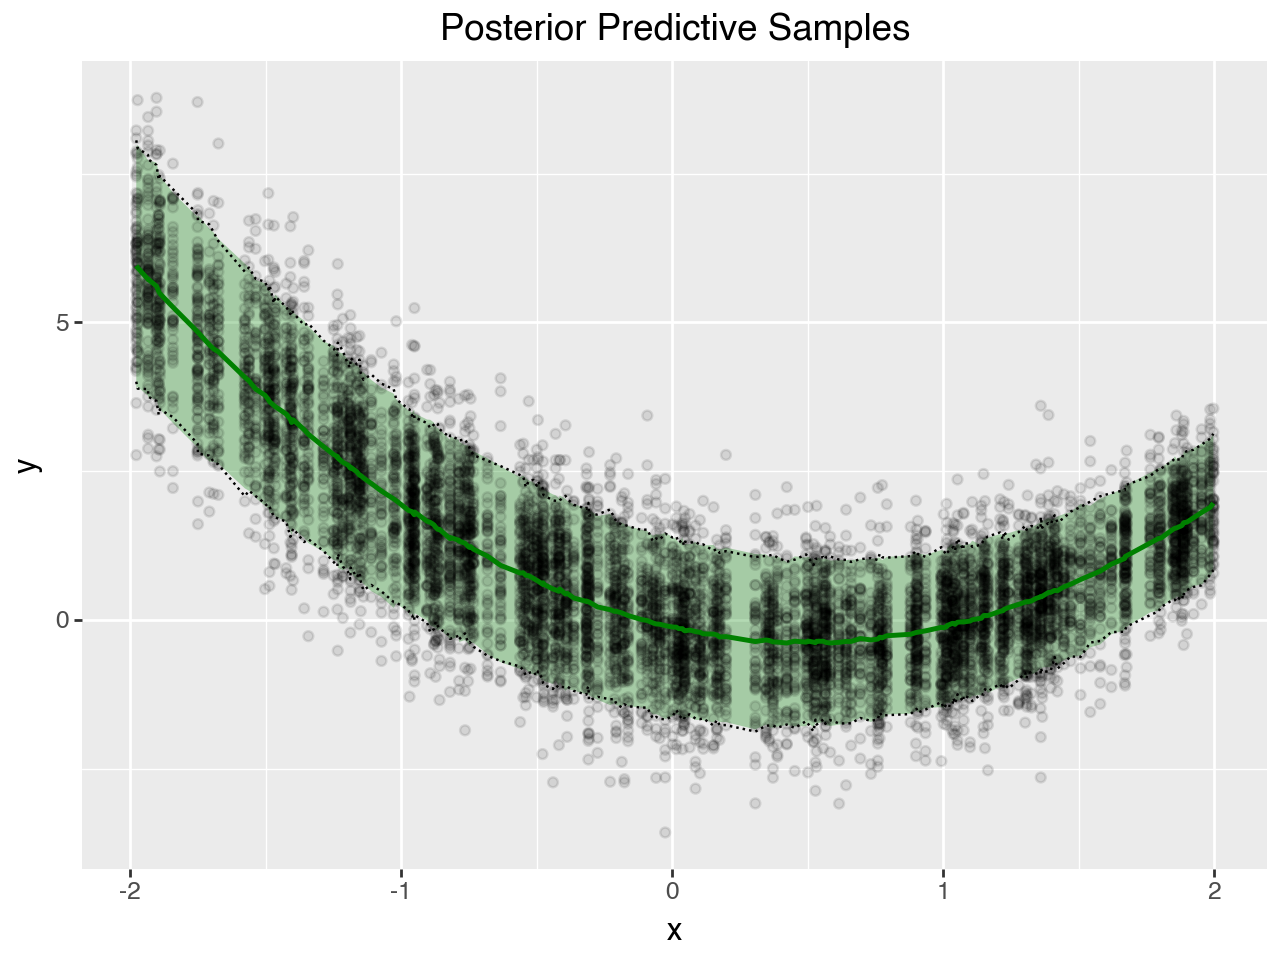

In [46]:
ppsamples_reshaped = ppsamples["y"].reshape(-1, *ppsamples["y"].shape[2:])
ppsamples_df = pd.DataFrame(ppsamples_reshaped.T)
ppsamples_df["x"] = df["x"].to_numpy()
ppsamples_df = ppsamples_df.melt(id_vars=["x"], value_name="y", var_name="sample")
ppsamples_df[ppsamples_df["sample"].isin(range(5))]


nsamples = 50


(
    p9.ggplot(ppsamples_df[ppsamples_df["sample"].isin(range(nsamples))])
    + p9.labs(title="Posterior Predictive Samples")
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95"),
        alpha=0.3,
        fill="green",
        data=ppsamples_summary,
    )
    + p9.geom_point(p9.aes("x", "y"), alpha=0.1)
    + p9.geom_line(p9.aes("x", "hdi_low"), linetype="dotted", data=ppsamples_summary)
    + p9.geom_line(p9.aes("x", "hdi_high"), linetype="dotted", data=ppsamples_summary)
    + p9.geom_line(p9.aes("x", "mean"), color="green", size=1, data=ppsamples_summary)
)